# Topographic profiles -  Mount Alpi (Lucania, Southern Italy)

*Doc started 2019-05-12*

*Current version: 2022-12-03*

*Last running version: 2022-08-02 (fully, with R) (only Python: 2022-12-03)* 

This notebook describes the calculation of topographic profiles. As input data we need a DEM and a profile. 

Figures are plotted via matplotlib:

In [25]:
%matplotlib inline

Data sets can be plotted with pprint:

In [26]:
from pprint import pprint

## DEM input

The source DEM is from publicly available Aster data and refers to the the Mt. Alpi zone (Lucania, Southern Italy):

In [27]:
source_data = "../../example_data/mt_alpi/malpi_aster_w4u3.tif"

We read the DEM info using a GDAL-based raster-band reader method:

In [28]:
from gst.io.rasters.gdal_io import read_raster_band
result, err = read_raster_band(raster_source=source_data)

In [29]:
print(err)

The raster was successfully read. The result is composed by a set of various infos:

In [30]:
geotransform, epsg, band_params, data = result

In [31]:
for info in (geotransform, epsg, band_params, data):
    print(f"info type: {type(info)}:\n\n{info}\n\n")

info type: <class 'pygsf.geometries.georeferencing.geotransform.GeoTransform'>:

[ 5.80814583e+05  2.72759535e+01  0.00000000e+00  4.44429946e+06
  0.00000000e+00 -2.72759531e+01]


info type: <class 'int'>:

32633


info type: <class 'dict'>:

{'dataType': 'Float32', 'unitType': '', 'stats': {'min': 0.0, 'max': 1829.0, 'mean': 1092.0445648248, 'std_dev': 302.5523744617}, 'noData': 3.4028234663852886e+38, 'numOverviews': 0, 'numColorTableEntries': 0}


info type: <class 'numpy.ndarray'>:

[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [1097. 1096. 1097. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...  638.  641.  647.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]




The EPSG projection code is 32633.

The 'data' variable stores the raster values as a Numpy array.

Using this information, we can compose a *GeoArray* instance. It combines the geotransform, the EPSG code and one or more arrays (in this case, only one array) into a georeferenced object, that can be considered a *grid*:

In [32]:
from pygsf.geometries.grids.rasters import Grid

grid = Grid(
    array = data,
    geotransform=geotransform)

We can plot this grid with a utility function:

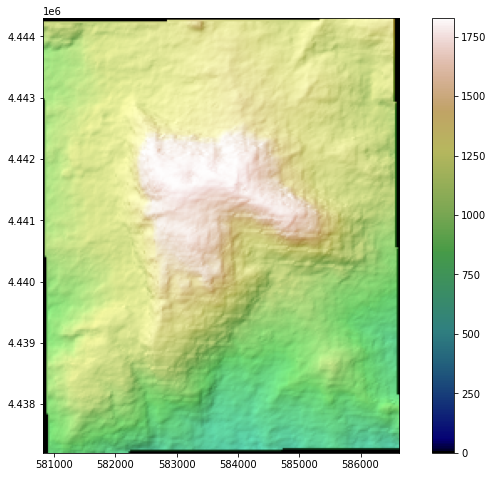

In [33]:
from gst.plots.parameters import *
from gst.plots.mpl import *

figure_parameters = FigurePlotParams(
    width=12,
    height=8
)

maps(
    grid,
    fig_params=figure_parameters
)

## Source profile definition

In order to digitally create a topographic/geological profile, we first need to define a trace with wich to extract elevations from DEMs and afterwards to manipulate geological layers. 

In this example, we read the trace from a line shapefile using a function based on GDAL/OGR.

In [34]:
from gst.io.vectors.ogr_io import try_read_line_shp_with_attr

src_profile_shapefile_pth = "../../example_data/mt_alpi/profile_2.shp"
success, result = try_read_line_shp_with_attr(src_profile_shapefile_pth)

In [35]:
print(success)

True


The result is composed by a list of GeoLines-attributes pairs (stored as tuples). Each attribute set is applicable to all of the GeoLine list elements: remember that the source layer could store MultiLines. In the current case, we have just a single record, composed by a list with a single line, an empty attribute tuple (last nested empty tuple in printed results) and the source data EPSG code.

In [36]:
print(result)

([([Ln with 5 points: Point([ 581836.80423    4442973.60243944]), Point([ 583086.78053975 4442107.47712245]), .., Point([ 585478.46749462 4440700.02348234]), Point([ 586078.84981662 4439991.37549571])], ())], 32633)


In [37]:
lines, epsg_code = result
print(lines)
print(epsg_code)

[([Ln with 5 points: Point([ 581836.80423    4442973.60243944]), Point([ 583086.78053975 4442107.47712245]), .., Point([ 585478.46749462 4440700.02348234]), Point([ 586078.84981662 4439991.37549571])], ())]
32633


In [38]:
first_record = lines[0]
profile_lines, attributes = first_record
profile_line = profile_lines[0]
print(profile_line)
print(attributes)

Ln with 5 points: Point([ 581836.80423    4442973.60243944]), Point([ 583086.78053975 4442107.47712245]), .., Point([ 585478.46749462 4440700.02348234]), Point([ 586078.84981662 4439991.37549571])
()


This line is 2D line, made up by 5 points.

The spatial reference of the line profile is EPSG: 32633, i.e. the same as that of raster DEM CRS. 
Therefore no projection change is required before plotting against the DEM.

Now we plot the profile trace in the previous figure.

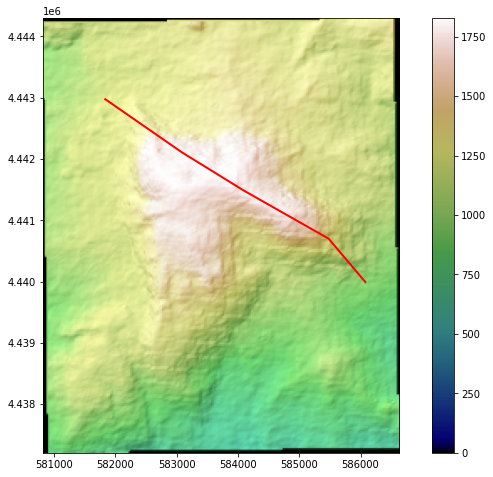

In [39]:
figure_parameters = FigurePlotParams(
    width=12,
    height=8
)

profile_parameters = ElevationPlotParams(
    color="red",
    width=2.0,
)

maps(        
    grid,
    lines = {
        'profile': {'data': [profile_line], 'params': profile_parameters},
    },
    fig_params=figure_parameters
)

### Initializing a line profiler

*gsf* uses the **profiler** concept to act as the protagonist in the profile process. A profiler is the object that stores the trace information and that knows how to interact with DEMs and geological layers in order to create, in a stepwise manner, a geological profile. Technically, a profiler stores a source line, its EPSG code and the sampling distance. It is therefore named **LineProfiler**.
In its essence, it corresponds to a list of segments, each with the same EPSG code and sampling distance.
It is the SegmentProfiler that really knows how to interact with DEMs and geological layers.

In [40]:
from pygsf.profiles.profilers import LineProfiler

Input parameters for the LineProfiler creation are the line, the densify distance and the EPSG code.

In [41]:
line_profiler = LineProfiler(
    src_line=profile_line)

Having created a LineProfiler instance, we can now use it on a DEM, to create a topographic profile.

In [42]:
topographic_profile, err = line_profiler.sample_grid(
    grid=grid,
    sampling_distance=10 # meters
)

In its essence, a topographic profile is a collection of x-y coordinates in a 2D space. It is embodied as a XYArrayPair, that is composed by a couple of Numpy arrays, representing the s and z coordinates, plus an optional array of break points, i.e., where the profile changes direction.  

In [43]:
print(err)

The list of break points along the profile is given by:

In [44]:
topographic_profile.x_breaks()

array([   0.        , 1520.72806236, 2700.70025808, 4296.28180226,
       5225.06643905])

To plot the profile, we use the *plot* function from the *plots.profiles_matplotlib* module.
The plot can be customized by passing keyword arguments, some of which are proper Matplotlib parameters:

### Analizing a topographic profile with R

Analyses of a profile could be, among others:
- profile smoothing
- calculate splines
- detrend data
- calculate Auto Correlation Function (ACF)


https://learning.oreilly.com/library/view/practical-time-series/9781492041641/ch06.html#idm45554596280744

In [45]:
data = topographic_profile.y_arr()

from: https://anderfernandez.com/en/blog/how-to-program-with-python-and-r-in-the-same-jupyter-notebook/

In [46]:
%load_ext rpy2.ipython

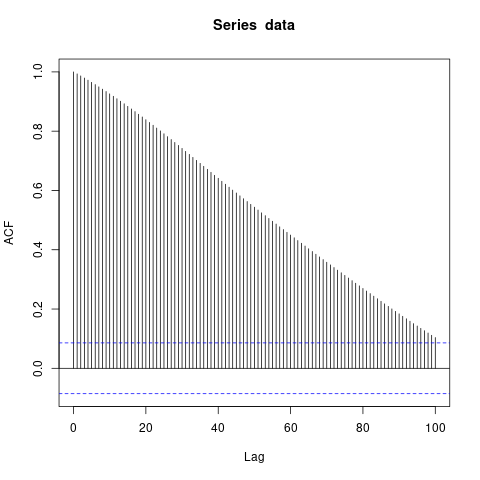

In [47]:
%%R -i data 
acf(data, lag.max=100)

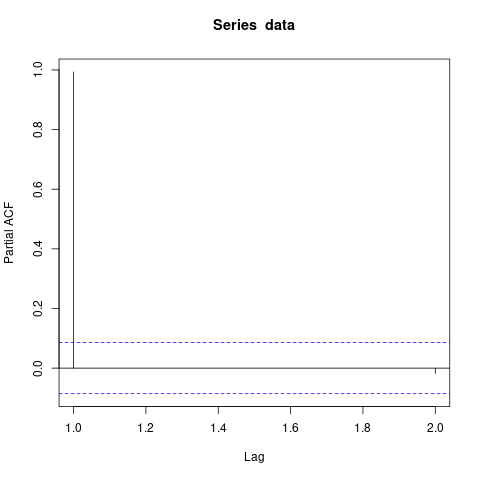

In [48]:
%%R -i data 
pacf(data, lag.max=2)

In [49]:
datadiff = data[1:] - data[:-1]

In [50]:
#datadiff

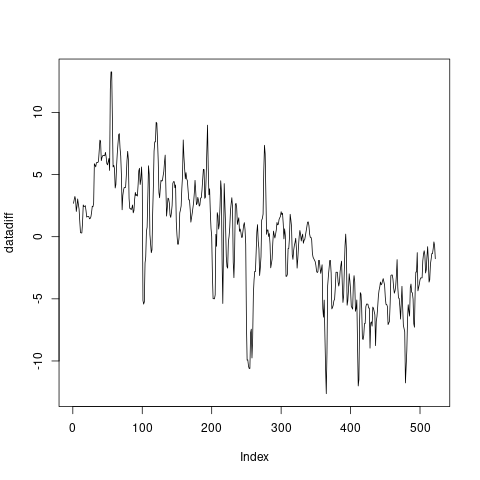

In [51]:
%%R -i datadiff 
plot(datadiff, type = "l")

In [52]:
datadiff2 = datadiff[50:400] - datadiff[49:399]

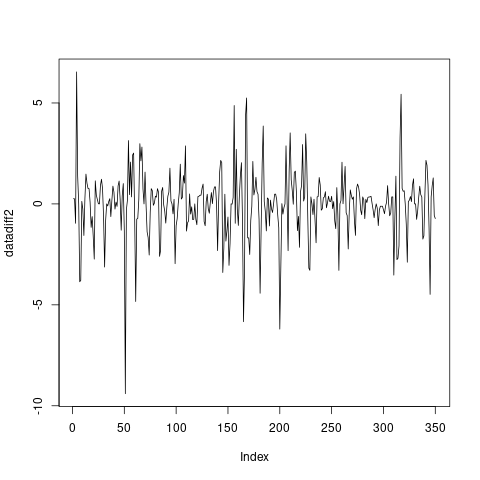

In [53]:
%%R -i datadiff2 
plot(datadiff2, type = "l")

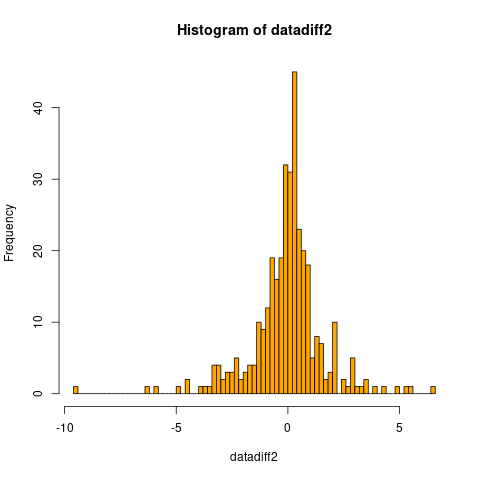

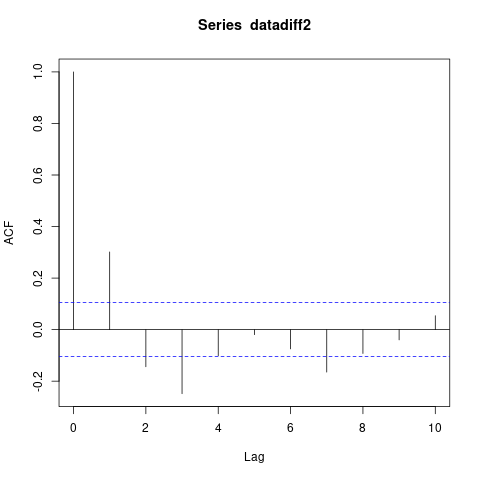

In [54]:
%%R -i datadiff2 
hist(datadiff2, col='orange', nclass=60)
acf(datadiff2, lag.max=10)

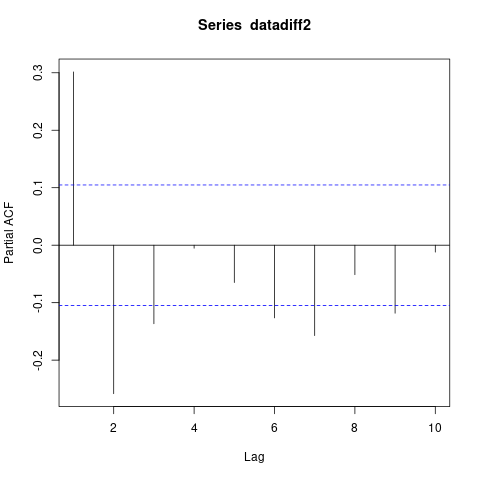

In [55]:
%%R -i datadiff2 
pacf(datadiff2, lag.max=10)

Moving average

from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy

In [56]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [57]:
smooth_50 = moving_average(data, 50)

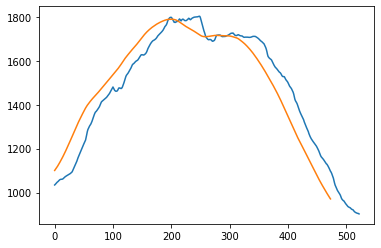

In [58]:
import matplotlib.pyplot as plt 
plt.plot(data)
plt.plot(smooth_50)

from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy

In [59]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

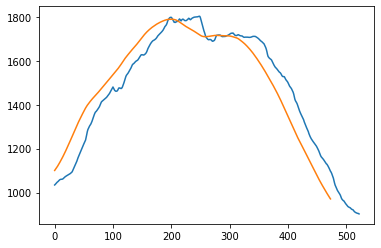

In [60]:
plt.plot(data)
plt.plot(moving_average(data, n=50))

from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.wiener.html#scipy.signal.wiener

In [61]:
from scipy.signal.signaltools import wiener

In [62]:
filtered_data = wiener(data, (50,))  #Filter the image

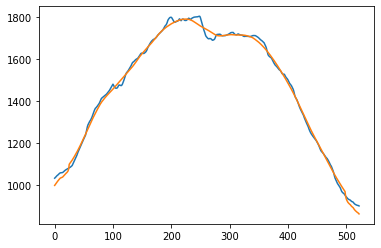

In [63]:
plt.plot(data)
plt.plot(filtered_data)

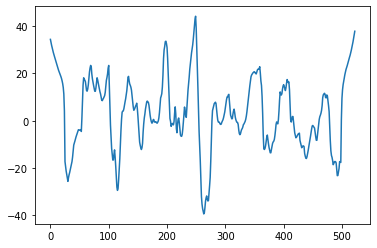

In [64]:
residuals = data - filtered_data
plt.plot(residuals)

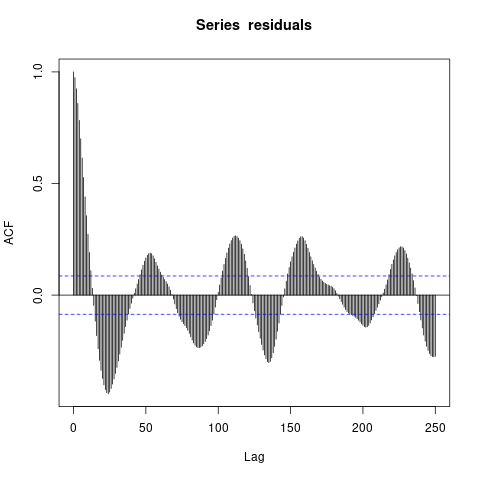

In [65]:
%%R -i residuals 
acf(residuals, lag.max=250)

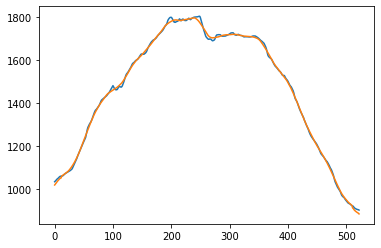

In [66]:
filtered_data = wiener(data, (25,))  #Filter the image
plt.plot(data)
plt.plot(filtered_data)

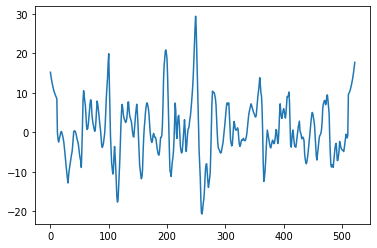

In [67]:
residuals = data - filtered_data
plt.plot(residuals)

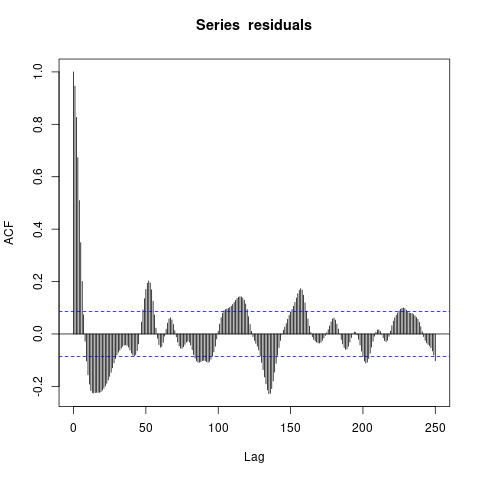

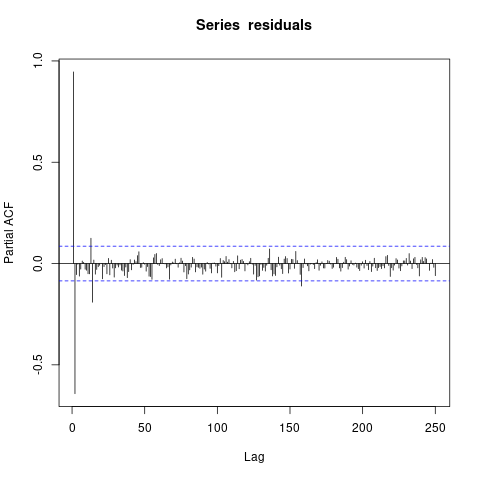

In [68]:
%%R -i residuals 
acf(residuals, lag.max=250)
pacf(residuals, lag.max=250)

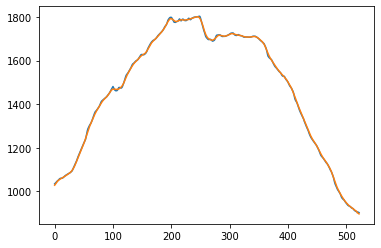

In [69]:
filtered_data = wiener(data, (10,))  #Filter the image
plt.plot(data)
plt.plot(filtered_data)

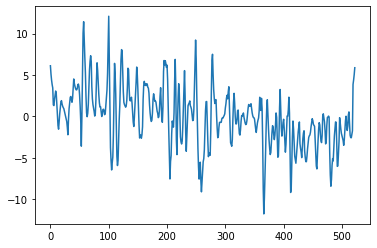

In [70]:
residuals = data - filtered_data
plt.plot(residuals)

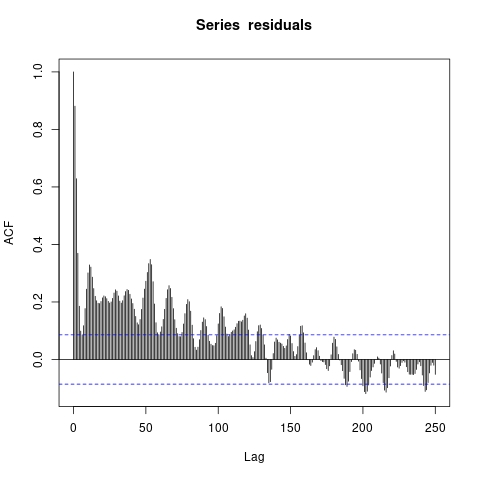

In [71]:
%%R -i residuals 
acf(residuals, lag.max=250)

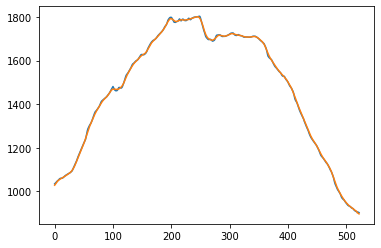

In [72]:
filtered_data = wiener(data, (10,))  #Filter the image
plt.plot(data)
plt.plot(filtered_data)

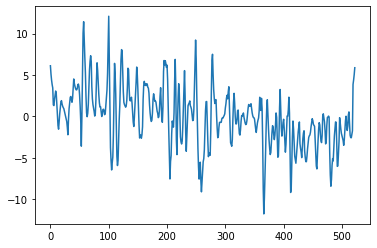

In [73]:
residuals = data - filtered_data
plt.plot(residuals)

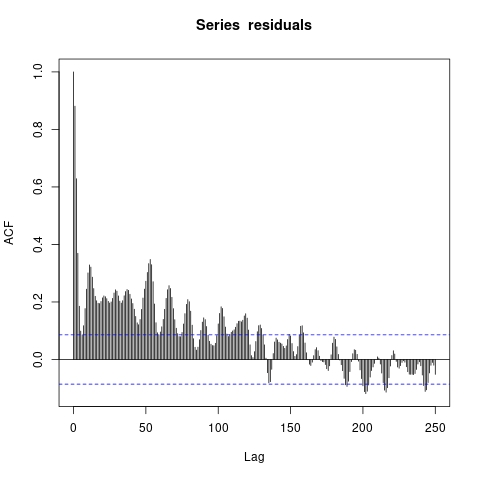

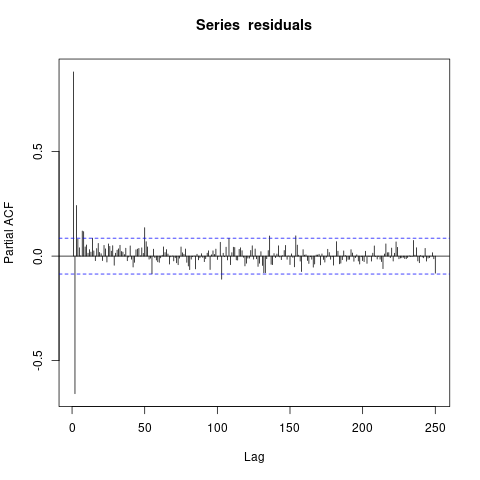

In [74]:
%%R -i residuals 
acf(residuals, lag.max=250)
pacf(residuals, lag.max=250)

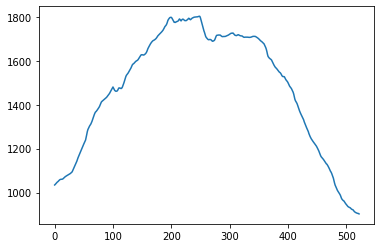

In [75]:
plt.plot(data)

from https://otexts.com/fpp2/non-seasonal-arima.html

In [76]:
%%R -i data 
library(forecast)
fit <- auto.arima(data, seasonal=FALSE)
fit

R[write to console]: Error in library(forecast) : there is no package called ‘forecast’

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages




Error in library(forecast) : there is no package called ‘forecast’


In [77]:
%%R -i data 
library(forecast)
fit <- auto.arima(data, seasonal=TRUE)
fit

R[write to console]: Error in library(forecast) : there is no package called ‘forecast’




Error in library(forecast) : there is no package called ‘forecast’


In [78]:
%%R
fit %>% forecast(h=15) %>% autoplot(include=50)

R[write to console]: Error in fit %>% forecast(h = 15) %>% autoplot(include = 50) : 
  could not find function "%>%"




Error in fit %>% forecast(h = 15) %>% autoplot(include = 50) : 
  could not find function "%>%"


In [79]:
%%R
fit <- auto.arima(data, seasonal=FALSE)
fit2 <- Arima(data, order=c(2,0,1))
fit2

R[write to console]: Error in auto.arima(data, seasonal = FALSE) : 
  could not find function "auto.arima"




Error in auto.arima(data, seasonal = FALSE) : 
  could not find function "auto.arima"


In [80]:
%%R
fit3 <- auto.arima(data, seasonal=FALSE,
  stepwise=FALSE, approximation=FALSE)
fit3

R[write to console]: Error in auto.arima(data, seasonal = FALSE, stepwise = FALSE, approximation = FALSE) : 
  could not find function "auto.arima"




Error in auto.arima(data, seasonal = FALSE, stepwise = FALSE, approximation = FALSE) : 
  could not find function "auto.arima"


In [81]:
%%R
fit4 <- auto.arima(data, seasonal=FALSE,
  stepwise=TRUE, approximation=FALSE)
fit4

R[write to console]: Error in auto.arima(data, seasonal = FALSE, stepwise = TRUE, approximation = FALSE) : 
  could not find function "auto.arima"




Error in auto.arima(data, seasonal = FALSE, stepwise = TRUE, approximation = FALSE) : 
  could not find function "auto.arima"


Various references:
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://perma.cc/P9BK-764B
- https://learning.oreilly.com/library/view/practical-time-series/9781492041641/ch06.html#idm45554595882376


Python-R connection help from:
 - https://thomas-cokelaer.info/blog/2012/04/how-to-call-r-plotting-function-from-python-using-rpy2/
  - https://blog.jupyter.org/i-python-you-r-we-julia-baf064ca1fb6
 
 I Python, You R, We Julia
Matthias Bussonnier
Matthias Bussonnier
May 29, 2018 · 8 min read
 